In [1]:
# fmt: off
from Interpretability.InterpretabilityMethods import *
from SequentialLearning.SequentialTasks.MNISTClassificationTask import MNISTClassificationTask
from SequentialLearning.EWC_Methods.EWC_Methods import *

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# fmt: on

In [2]:
MODEL_SAVE_PATH = "models/mnist_intepretability_model"
LOAD_MODEL = False
TRAIN_MODEL = not LOAD_MODEL

task_digit_labels = [1,2,3]
epochs = 5
training_batches = 300
validation_batches = 100
batch_size = 32
ewc_method = EWC_Method.NONE

In [3]:
model: tf.keras.Model
if LOAD_MODEL and os.path.exists(MODEL_SAVE_PATH):
    # Try to load model directly, if one exists
    print("LOADING MODEL")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)  # type: ignore
else:
    # Otherwise, make an entire new model!
    print("CREATING MODEL")
    model_input_shape = (28,28,1)
    model_inputs = model_layer = tf.keras.Input(shape=model_input_shape)
    model_layer = tf.keras.layers.Conv2D(9, (3,3), activation="relu")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(9, (3,3), activation="relu")(model_layer)
    model_layer = tf.keras.layers.Conv2D(9, (3,3), activation="relu")(model_layer)
    model_layer = tf.keras.layers.Flatten()(model_layer)
    model_layer = tf.keras.layers.Dense(10, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(len(task_digit_labels))(model_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=model_layer, name="model")

if len(task_digit_labels) == 2:
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.summary()

CREATING MODEL
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 9)         90        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 9)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 9)         738       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 9)           738       
                                                                 
 flatten (Flatten)           (None, 729)               0         
                                              

In [4]:
task = MNISTClassificationTask(
        name=f"Task 0",
        model=model,
        model_base_loss=loss_fn,
        task_digit_labels=task_digit_labels,
        training_batches = training_batches,
        validation_batches = validation_batches,
        batch_size=batch_size
    )
task.compile_model(loss_fn)

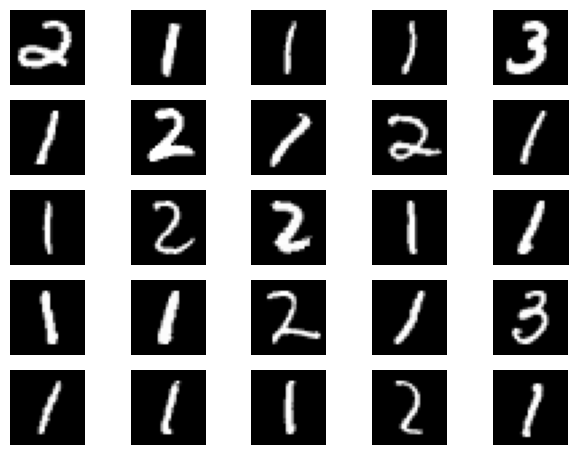

In [5]:
# Show some images from the task dataset
data = task.validation_dataset.take(1)
data_images, data_labels = data.as_numpy_iterator().next()
data_images = data_images[:25]
data_labels = data_labels[:25]
plot_images(data_images, cmap="gray")

In [6]:
if TRAIN_MODEL:
    checkpoint_path = MODEL_SAVE_PATH+"/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1)
    history = task.train_on_task(epochs=epochs, callbacks=[
        # checkpoint_callback,
    ])
    model.save(MODEL_SAVE_PATH)

Epoch 1/5
300/300 [==============================] - 8s 17ms/step - loss: 0.2077 - base_loss: 0.2077 - val_loss: 0.0622 - val_base_loss: 0.0622
Epoch 2/5
300/300 [==============================] - 5s 16ms/step - loss: 0.0766 - base_loss: 0.0766 - val_loss: 0.0399 - val_base_loss: 0.0399
Epoch 3/5
300/300 [==============================] - 4s 14ms/step - loss: 0.0480 - base_loss: 0.0480 - val_loss: 0.0289 - val_base_loss: 0.0289
Epoch 4/5
297/300 [============================>.] - ETA: 0s - loss: 0.0335 - base_loss: 0.0335

OPERATING ON conv2d_2


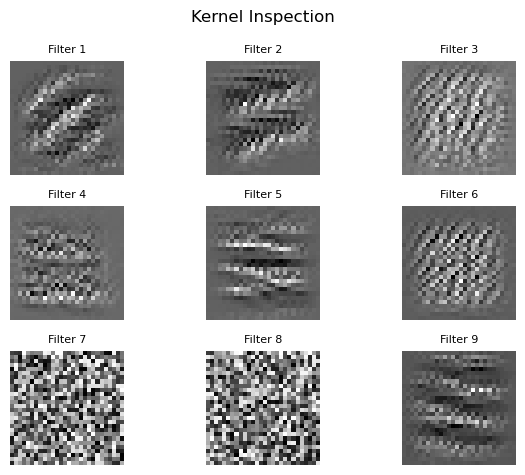

In [ ]:
kernel_inspection(model=task.model, steps=500, step_size=0.05)

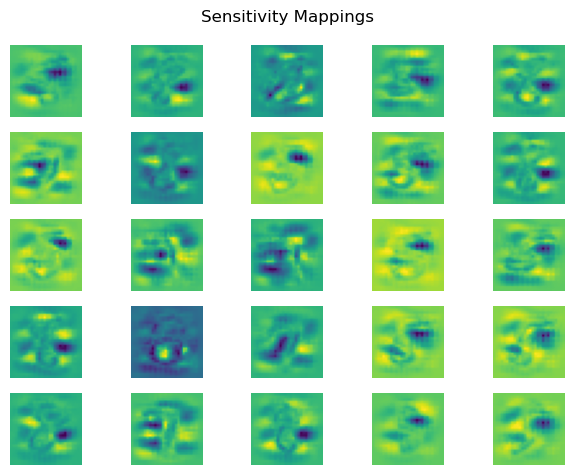

In [ ]:
occlusion_sensitivity(task.model, data_images, data_labels, patch_size=2, stride=1)

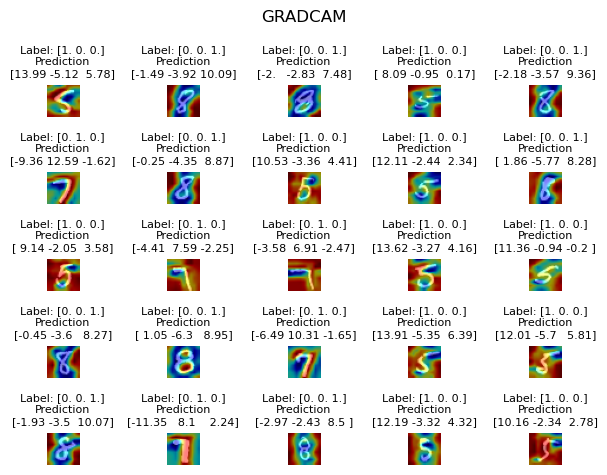

In [ ]:
GRADCAM(model, data_images, data_labels, show_predictions=False)